<a href="https://colab.research.google.com/github/Kovalivska/retail_demand_forecast/blob/main/Example_Equador_ARIMA_XGBoost_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. ARIMA/ SARIMA

## 1.1. Install DARTS and libreries


In [28]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 972.2/972.2 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00


## 1.2.Connect to Goole Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.3. Read the files with pandas

In [ ]:
# Load the CSV files into pandas DataFrames

df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

## 1.4. Prepare data

In [24]:
# Let's filter the data for one store and one item to keep it simple
store_ids = [1] # the store that we select
item_ids = [96995] # the item that we select

# Select data before April'14
max_date = '2014-04-01'

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[(chunk['store_nbr'].isin(store_ids)) & (chunk['item_nbr'].isin(item_ids)) & (chunk['date']<max_date)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_filtered = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-24-d15809e78600>:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):


In [25]:
df_filtered.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,324276,2013-01-10,1,96995,1.0,NaN
1,362634,2013-01-11,1,96995,1.0,NaN
2,486204,2013-01-14,1,96995,1.0,NaN
3,644444,2013-01-18,1,96995,2.0,NaN
4,770056,2013-01-21,1,96995,1.0,NaN


In [29]:
import pandas as pd
from darts import TimeSeries


In [30]:
#to convert the 'date' column to the date-time type and aggregate sales by date, replacing zero sales
# Reset index to make sure 'date' is still a column
df_filtered = df_filtered.reset_index()

df_filtered['date'] = pd.to_datetime(df_filtered['date'])
df_filtered = df_filtered.groupby('date').sum()['unit_sales'].reset_index()


# Setting an index after the aggregation made
df_filtered.set_index('date', inplace=True)

# Fill missing dates with zero sales (since some dates may have no sales)
df_filtered = df_filtered.asfreq('D').fillna(0)

# Convert to a Darts TimeSeries object
series = TimeSeries.from_dataframe(df_filtered, value_cols='unit_sales')

## 1.5. Splitting the Data into Training and Testing Sets

In [31]:
# Split the data (80% training, 20% testing)
train, test = series.split_after(0.8)

<Axes: xlabel='date'>

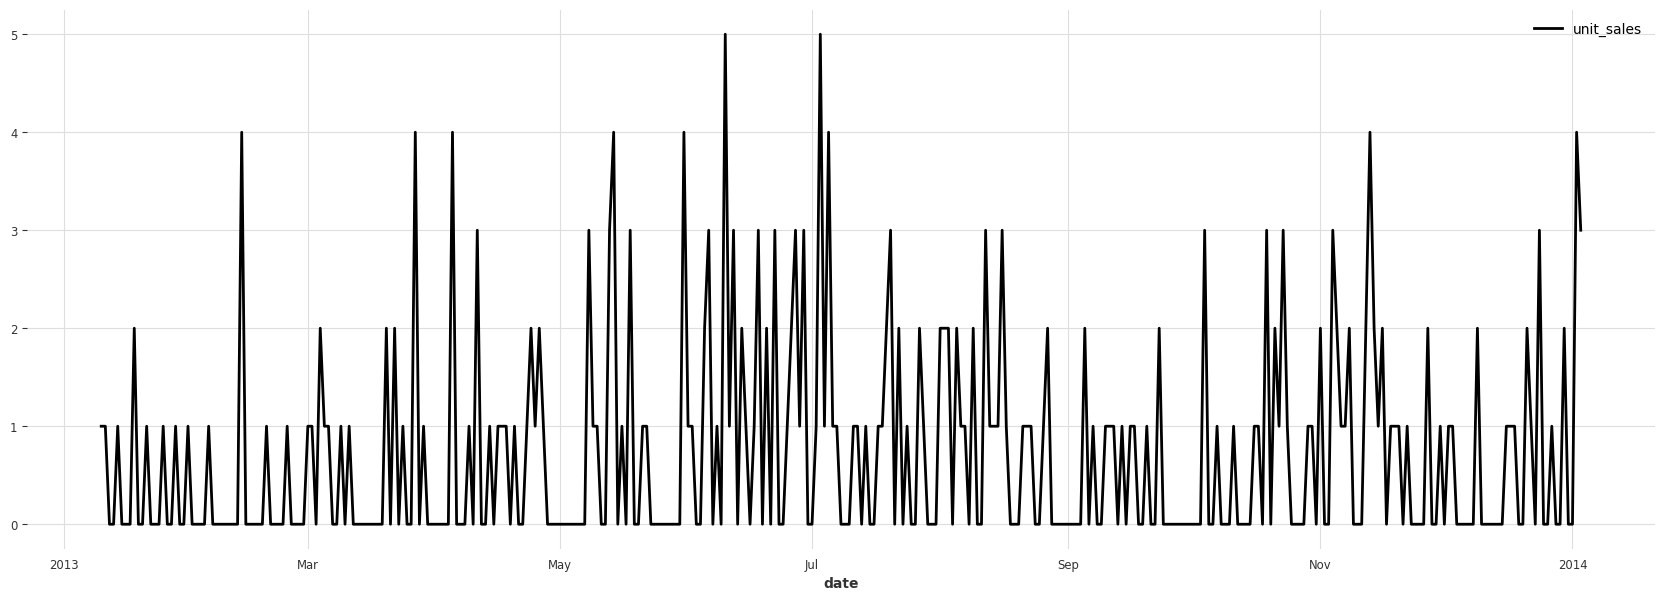

In [32]:
import matplotlib.pyplot as plt
# Visualize the filtered sales data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
series.plot()

## 1.6. Fit model ARIMA

In [34]:
pip install dask

In [35]:
from darts.models import ARIMA

# Initialize ARIMA model with (p, d, q) parameters
arima_model = ARIMA(p=5, d=1, q=0)

We initialize an ARIMA model with an order of (5, 1, 0), which means:
p=5: We are using 5 previous observations (autoregressive terms).
d=1: The data is differenced once to make it stationary.
q=0: No moving average terms are used.
p, d and q can significantly impact the way the model is performed, so selecting them properly is the key. The best way to select these three parameters is via ACF and PACF charts!

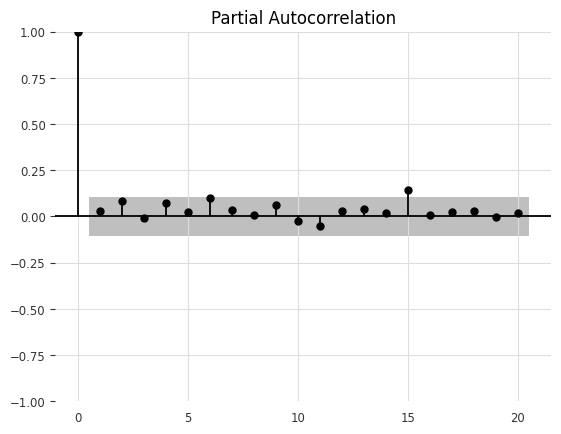

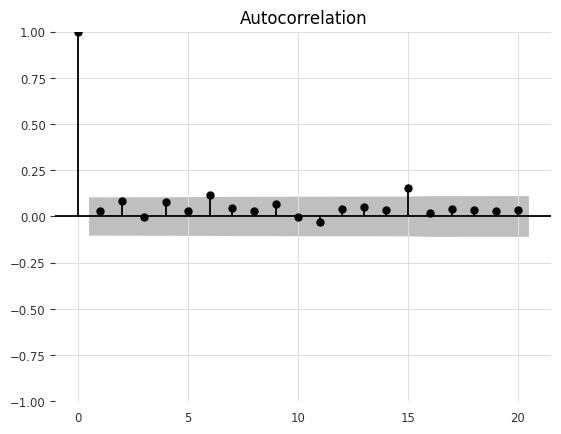

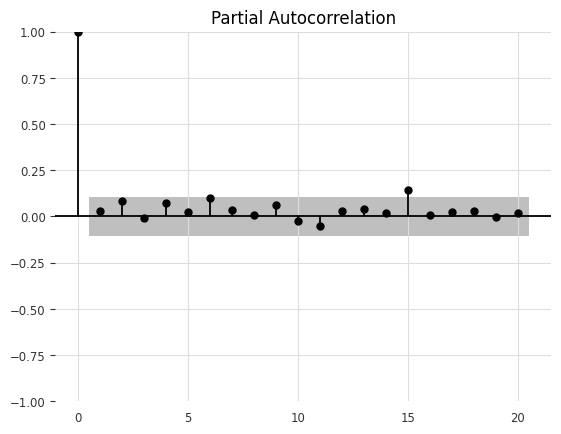

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_filtered['unit_sales'], lags=20)
plot_pacf(df_filtered['unit_sales'], lags=20)

In [ ]:
# def model_evaluation(model, test_size = 12, exog=None):
#     '''
#     This function evaluates the model on a given test size
#     '''
#     train_predictions = model.predict()
#     if exog is not None:
#         forecast = model.get_forecast(test_size, exog = df[-test_size:][exog])
#         test_predictions = forecast.predicted_mean
#     else:
#         try:
#             test_predictions = model.forecast(test_size)
#         except:
#             test_predictions = model.predict(test_size)
#     print(len(test_predictions))
#     mae = mean_absolute_error(df[-test_size:]['unit_sales'], test_predictions)
#     r2 = r2_score(df[-test_size:]['unit_sales'], test_predictions)
#     print(f'R2 score {np.round(r2,2)}\nMean absolute error {np.round(mae,2)}')
#     fig, ax = plt.subplots()
#     ax.plot(train_predictions, label = 'Train predictions')
#     ax.plot(df['unit_sales'], label = 'Input data')
#     ax.plot(test_predictions, label = 'Test predictions')
#     plt.legend()
#     plt.show()

<Axes: xlabel='date'>

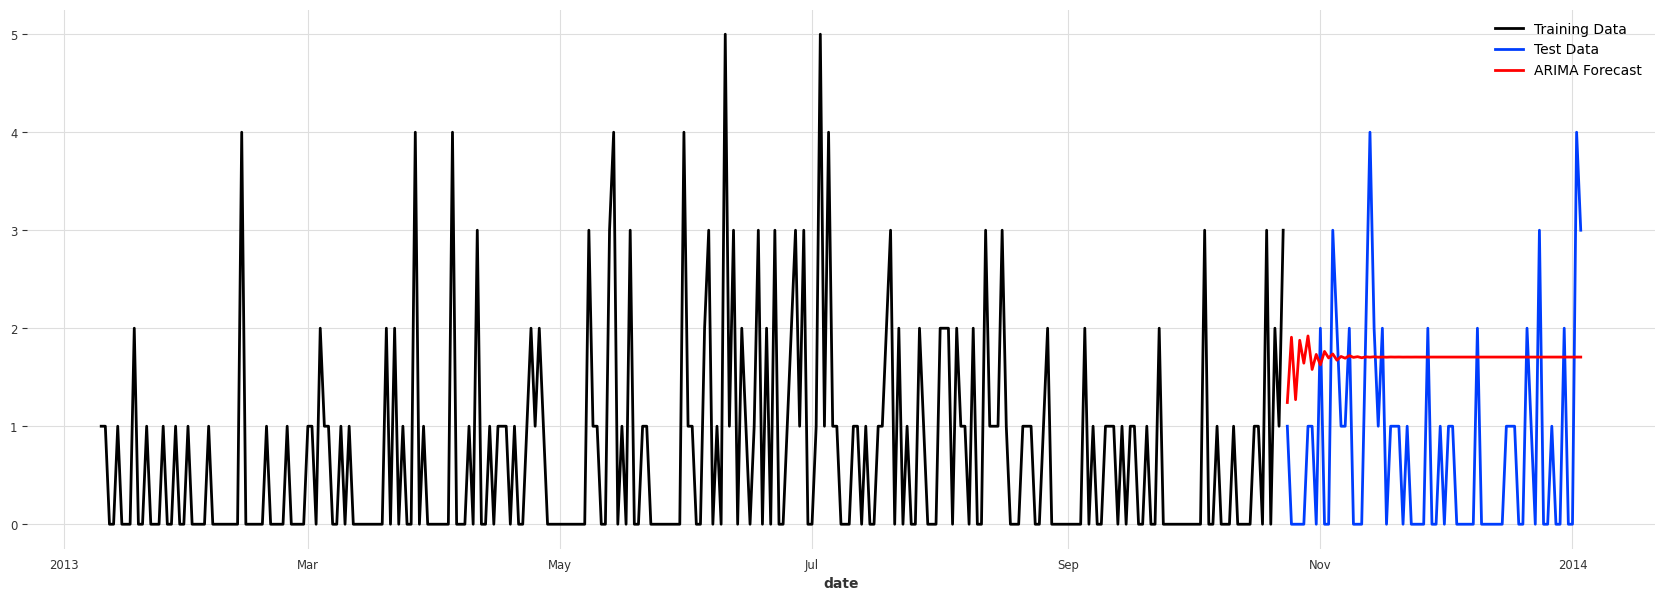

In [37]:
# Fit the ARIMA model on the training data
arima_model=arima_model.fit(train)

# Forecast the next values (the same length as the test set)
arima_forecast = arima_model.predict(len(test))

# Plot ARIMA forecast vs actual data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
train.plot(label='Training Data')
test.plot(label='Test Data')
arima_forecast.plot(label='ARIMA Forecast', color='red')

In [ ]:
# model_evaluation(arima_model.fit(train))

TypeError: TransferableFutureCovariatesLocalForecastingModel.predict() missing 1 required positional argument: 'n'

## 1.7. Fit the model **SARIMA**

In [38]:
!pip install --upgrade darts

In [39]:
from darts.models import *

# This will show all available models in the 'models' module
dir()

['ARIMA',
 'AutoARIMA',
 'BATS',
 'BlockRNNModel',
 'CatBoostModel',
 'ConformalNaiveModel',
 'ConformalQRModel',
 'Croston',
 'DLinearModel',
 'Dense',
 'Dropout',
 'EnsembleModel',
 'ExponentialSmoothing',
 'FFT',
 'FourTheta',
 'GaussianProcessFilter',
 'GlobalNaiveAggregate',
 'GlobalNaiveDrift',
 'GlobalNaiveSeasonal',
 'In',
 'KalmanFilter',
 'KalmanForecaster',
 'LSTM',
 'LightGBMModel',
 'LinearRegressionModel',
 'MinMaxScaler',
 'MovingAverageFilter',
 'NBEATSModel',
 'NHiTSModel',
 'NLinearModel',
 'NaiveDrift',
 'NaiveEnsembleModel',
 'NaiveMean',
 'NaiveMovingAverage',
 'NaiveSeasonal',
 'Out',
 'Prophet',
 'RNNModel',
 'RandomForest',
 'RegressionEnsembleModel',
 'RegressionModel',
 'Sequential',
 'StatsForecastAutoARIMA',
 'StatsForecastAutoCES',
 'StatsForecastAutoETS',
 'StatsForecastAutoTBATS',
 'StatsForecastAutoTheta',
 'TBATS',
 'TCNModel',
 'TFTModel',
 'TSMixerModel',
 'Theta',
 'TiDEModel',
 'TimeSeries',
 'TransformerModel',
 'VARIMA',
 'X',
 'XGBModel',
 'X_tes

In [40]:
!pip install pmdarima

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

<Axes: xlabel='date'>

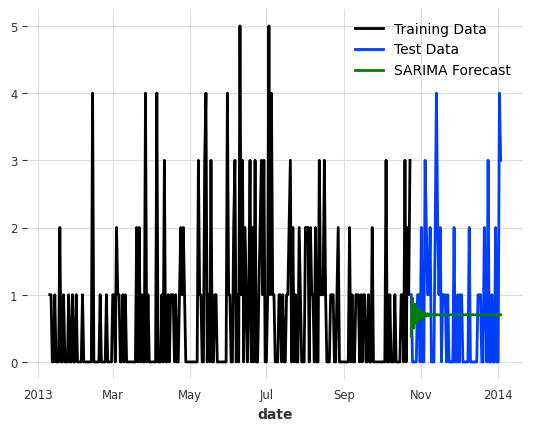

In [41]:
from pmdarima import auto_arima

from darts.models import AutoARIMA

# Initialize and train the SARIMA model with seasonal order (P,D,Q,m)
sarima_model = AutoARIMA((5,1,1), seasonal_order=(1, 1, 1, 7))  # Weekly seasonality
sarima_model.fit(train)

# Forecast for the test set
sarima_forecast = sarima_model.predict(len(test))

# Plot SARIMA results against the actual test data
train.plot(label='Training Data')
test.plot(label='Test Data')
sarima_forecast.plot(label='SARIMA Forecast', color='green')

Shortcomings of ARIMA and SARIMA Methods:
While ARIMA and SARIMA are powerful time-series forecasting techniques, they have some limitations:
Stationarity Requirement: Both ARIMA and SARIMA assume that the data is stationary, meaning that its statistical properties (like mean and variance) do not change over time. This often requires transforming or differencing the data, which can be challenging for complex, non-linear series.
Limited Non-Linearity Handling: ARIMA and SARIMA are linear models, meaning they may struggle to capture complex non-linear relationships in the data.
Seasonality Issues: SARIMA can handle seasonality, but only if it is consistent and well-defined. If seasonality changes over time or if there are multiple seasonal patterns, SARIMA might not perform well.
High Computational Cost for Large Data: Fitting ARIMA or SARIMA models can be computationally expensive when dealing with large datasets or long time series, as the models need to iterate over many lags.
No Exogenous Variables Support in Basic ARIMA/SARIMA: While ARIMA and SARIMA can model the data based on its own past values, they do not easily incorporate external influences (exogenous variables) unless you use extensions like ARIMAX.
There are many other classical methods, which don’t have such shortcomings, e.g Exponential Smoothing  or ARIMAX (AutoRegressive Moving Average with Exogenous Variables). We won’t cover them in our lessons, but if you would like to learn more about classical time-series methods, please check out the additional materials suggested for this week.


<Axes: xlabel='date'>

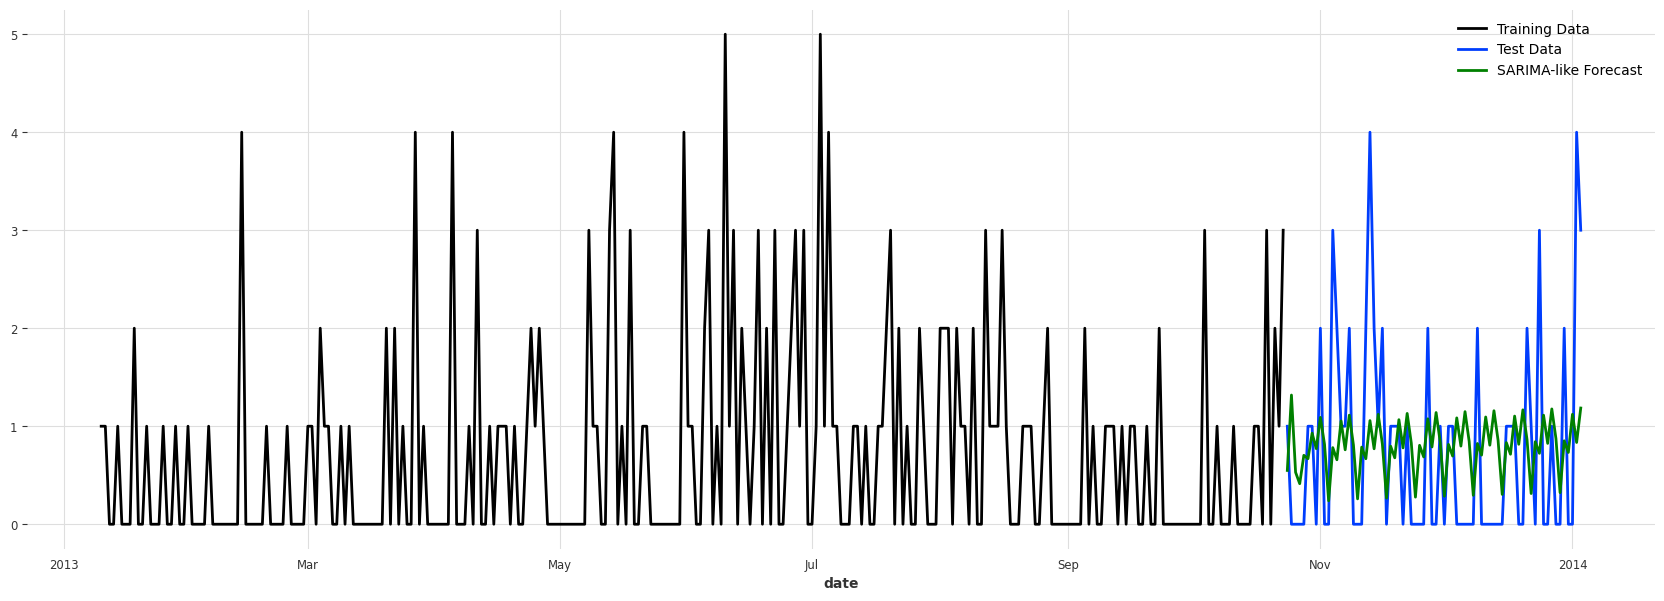

In [42]:
from darts.models import ARIMA

# Initialize ARIMA model with both (p, d, q) and (P, D, Q, m) parameters
# (P, D, Q, m) = (1, 1, 1, 7) for seasonal components (e.g., weekly seasonality)
sarima_like_model = ARIMA(p=5, d=1, q=1, seasonal_order=(1, 1, 1, 7))

# Fit the ARIMA model with seasonality on the training data
sarima_like_model.fit(train)

# Forecast the next values (the same length as the test set)
sarima_forecast = sarima_like_model.predict(len(test))

# Plot SARIMA-like forecast vs actual data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
train.plot(label='Training Data')
test.plot(label='Test Data')
sarima_forecast.plot(label='SARIMA-like Forecast', color='green')


# 2. Build XGBoost model for demand forecasting

# 2.1. Setting up the Environment and Loading Data


In [ ]:
# Install the xgboost library
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 5.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [ ]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/stores.csv')
df_items = pd.read_csv('/content/items.csv')
df_transactions = pd.read_csv('/content/transactions.csv')
df_oil = pd.read_csv('/content/oil.csv')
df_holidays_events = pd.read_csv('/content/holidays_events.csv')

In [ ]:
!apt-get install -y p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [ ]:
!7z e train.csv.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,96 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 474092593 bytes (453 MiB)

Extracting archive: train.csv.7z
--
Path = train.csv.7z
Type = 7z
Physical Size = 474092593
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - train.csv                  1% - train.csv                  2% - train.csv                  3% - train.csv                  4% - train.csv                  5% - train.csv                  6% - train.csv                  7% - train.csv                  8% - train.csv

In [ ]:
# Let's filter the data for one store and one item to keep it simple
store_ids = [1]
item_ids = [96995]
#Select data before April'14
max_date = '2014-04-01'


# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[(chunk['store_nbr'].isin(store_ids)) & (chunk['item_nbr'].isin(item_ids)) & (chunk['date']<max_date)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_filtered = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-8-cfae62105b55>:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/train.csv', chunksize=chunk_size):


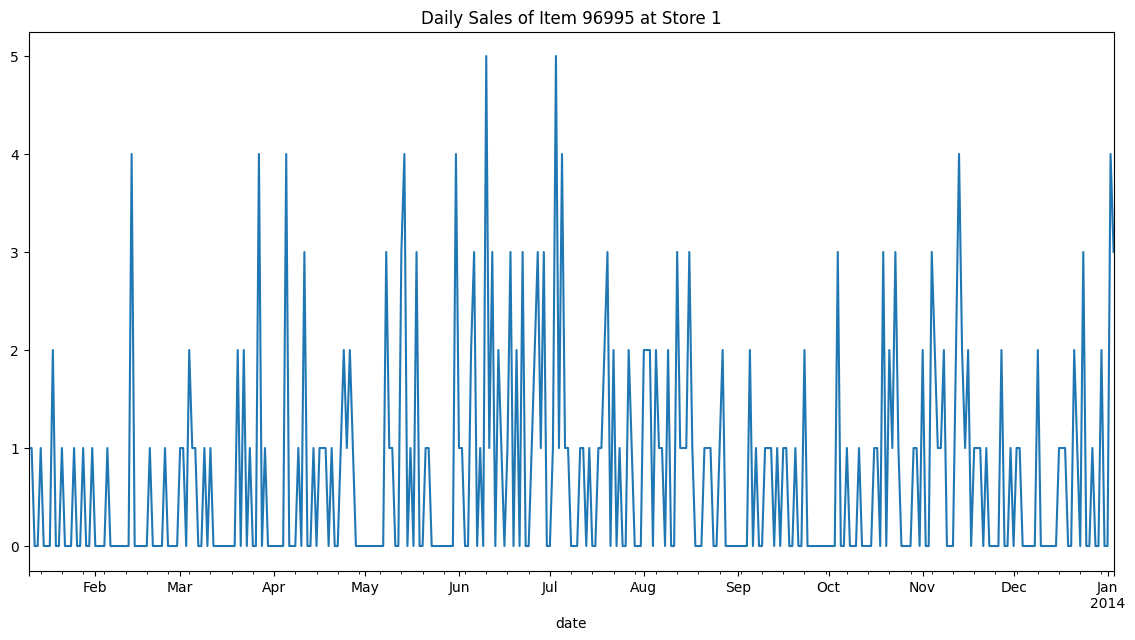

In [ ]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Group by date and aggregate sales
df_filtered = df_filtered.groupby('date').sum()['unit_sales'].reset_index()

# Fill missing dates with zero sales
df_filtered.set_index('date', inplace=True)
df_filtered = df_filtered.asfreq('D').fillna(0)

# Visualize sales data
plt.figure(figsize=(14, 7))
df_filtered['unit_sales'].plot()
plt.title('Daily Sales of Item 96995 at Store 1')
plt.show()

#2.2 Feature Engineering for Machine Learning


Supervised machine learning models (like xgboost) require a collection of input features, so we need to engineer meaningful features from our time-series data in order to use xgboost. Some of the most important features for time-series forecasting are lag features and rolling statistics. Let’s make these features now!

## 2.2.1. Creating Lag Features


In [ ]:
# Create lag features (e.g., sales from the previous day, previous week)
df_filtered['lag_1'] = df_filtered['unit_sales'].shift(1)
df_filtered['lag_7'] = df_filtered['unit_sales'].shift(7)
df_filtered['lag_30'] = df_filtered['unit_sales'].shift(30)

# Drop any rows with NaN values after creating lag features
df_filtered.dropna(inplace=True)

## 2.2.2. Creating Rolling Statistics


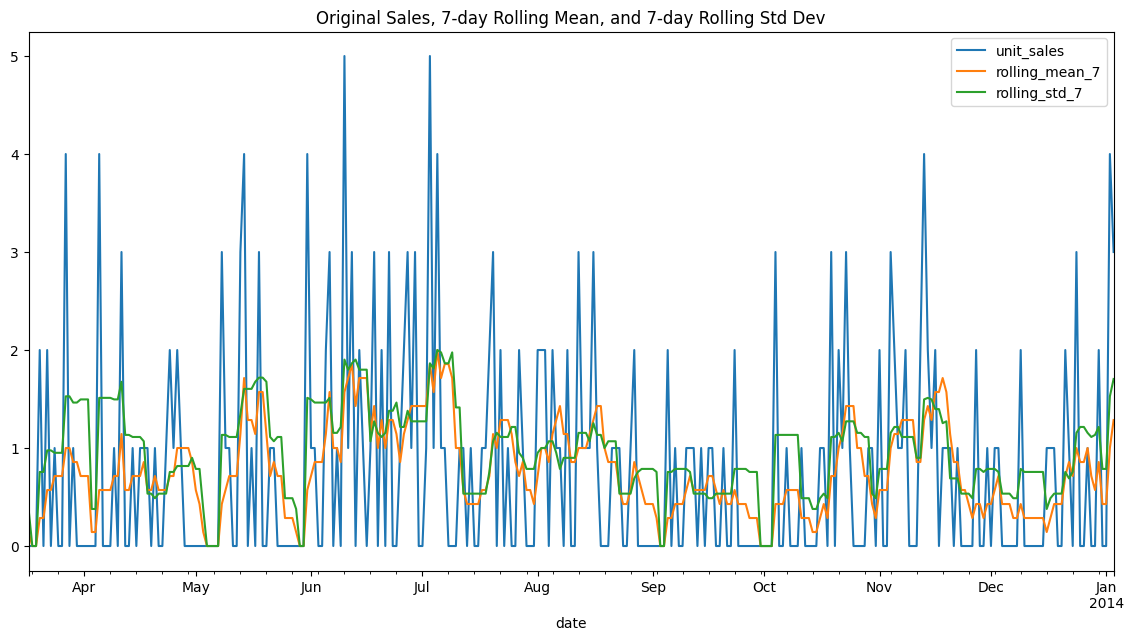

In [ ]:
#Creating Rolling Statistics# Create rolling mean and rolling standard deviation features
df_filtered['rolling_mean_7'] = df_filtered['unit_sales'].rolling(window=7).mean()
df_filtered['rolling_std_7'] = df_filtered['unit_sales'].rolling(window=7).std()

# Drop any NaN values after creating rolling features
df_filtered.dropna(inplace=True)

# Visualize the new features alongside the original sales
df_filtered[['unit_sales', 'rolling_mean_7', 'rolling_std_7']].plot(figsize=(14, 7))
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.show()

## 2.2.3. Adding Date-based Features

In [ ]:
# Add date-based features
df_filtered['day_of_week'] = df_filtered.index.dayofweek
df_filtered['month'] = df_filtered.index.month
df_filtered['is_weekend'] = df_filtered['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# 2.3. Splitting Data into Training and Testing Sets

In [ ]:
# Define target variable (unit_sales) and features
X = df_filtered.drop('unit_sales', axis=1)
y = df_filtered['unit_sales']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 2.4. Implementing XGBoost for Time-Series Forecasting

In [ ]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=15, learning_rate=0.01, subsample=1, colsample_bytree=0.7)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

In [ ]:
#Evaluate model
# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

r2 = xgboost_model.score(X_test, y_test)
print(f'R-squared (R2) Score: {r2}')


Mean Squared Error (MSE): 0.9884022509033945
Root Mean Squared Error (RMSE): 0.994184213766943
R-squared (R2) Score: 0.06959755668071488


In [ ]:
from sklearn.metrics import mean_absolute_error, explained_variance_score

mae = mean_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Explained Variance Score (EVS): {evs}")


Mean Absolute Error (MAE): 0.8169687290565443
Explained Variance Score (EVS): 0.12200416962860405


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           scoring='neg_mean_squared_error',  # Optimize for MSE
                           n_jobs=-1,  # Use all cores
                           verbose=1)

grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Use the best model
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 300, 'subsample': 1.0}


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validated MSE: {cv_scores.mean()} (std: {cv_scores.std()})")


Cross-validated MSE: -1.1988391575483537 (std: 0.43483701660075763)


In [ ]:
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=300,
                                 max_depth=15,
                                 learning_rate=0.01,
                                 alpha=0.1,   # L1 regularization
                                 lambda_=0.1) # L2 regularization
                                 # Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:19:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
#Evaluate model
# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

r2 = xgboost_model.score(X_test, y_test)
print(f'R-squared (R2) Score: {r2}')


Mean Squared Error (MSE): 1.1458186160772754
Root Mean Squared Error (RMSE): 1.0704291737790388
R-squared (R2) Score: -0.07858155829231905


In [ ]:
from sklearn.metrics import mean_absolute_error, explained_variance_score

mae = mean_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Explained Variance Score (EVS): {evs}")


Mean Absolute Error (MAE): 0.8715031624345456
Explained Variance Score (EVS): -0.018925874280497634


In [ ]:
# 5. Plotting Actual vs Predicted Values


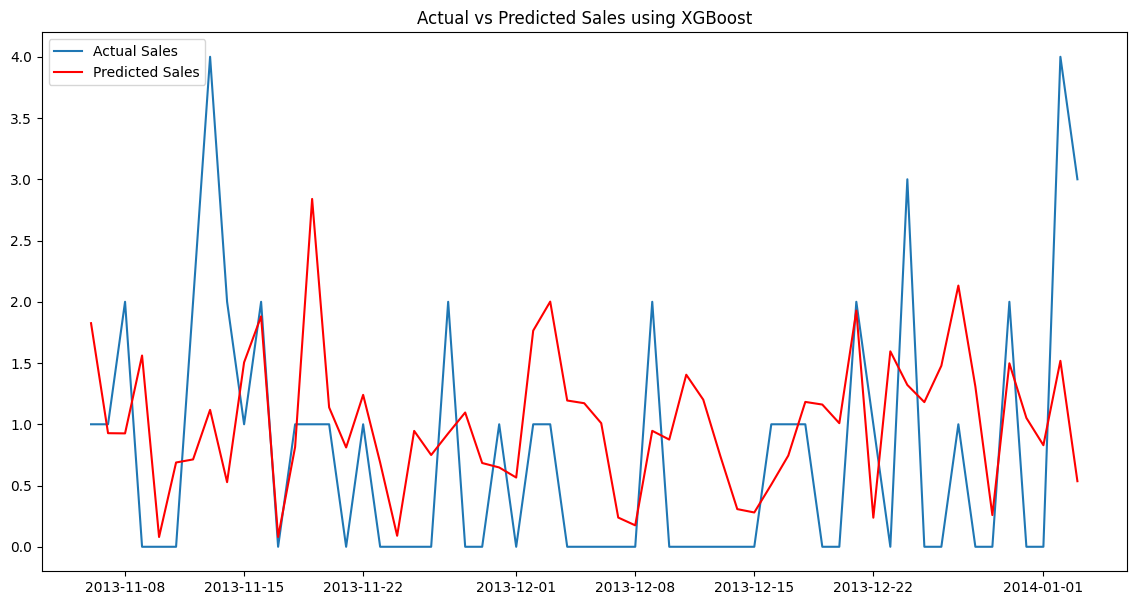

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

Key Takeaways
☝
Feature Engineering
We created lag features, rolling statistics, and date-based features to help the XGBoost model capture temporal dependencies in the sales data.
☝
Machine Learning
XGBoost was trained on these features to predict future sales. It’s a flexible and powerful tool that can handle non-linear relationships and multiple input features.
☝
Performance
By evaluating the Mean Squared Error (MSE), we can assess how well the model predicted future sales. You can further tune the model by adjusting parameters like n_estimators and max_depth.

You can find Colab notebook with example of the code used in this lesson here:
https://drive.google.com/file/d/1Jd3SjtqBJV11s0twjHVvHR6r0qCWmvNb/view?usp=drive_link
You have “Viewer” (read-only) access to the notebooks. To run and modify them, copy it in your Google-Drive space.

# 3. Practice of LSTM on Demand Forecasting Dataset

# 3.1 Import all libraries we will need

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 3.2.Connect to Goole Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3.3. Read the files with pandas

In [9]:
# Load the CSV files into pandas DataFrames

df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

In [10]:
# Let's filter the data for one store and one item to keep it simple
store_ids = [1]
item_ids = [96995]
#Select data before April'14
max_date = '2014-04-01'


# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[(chunk['store_nbr'].isin(store_ids)) & (chunk['item_nbr'].isin(item_ids)) & (chunk['date']<max_date)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_filtered = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-10-bd7586eec8b9>:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):


# 3.4. Prepare data

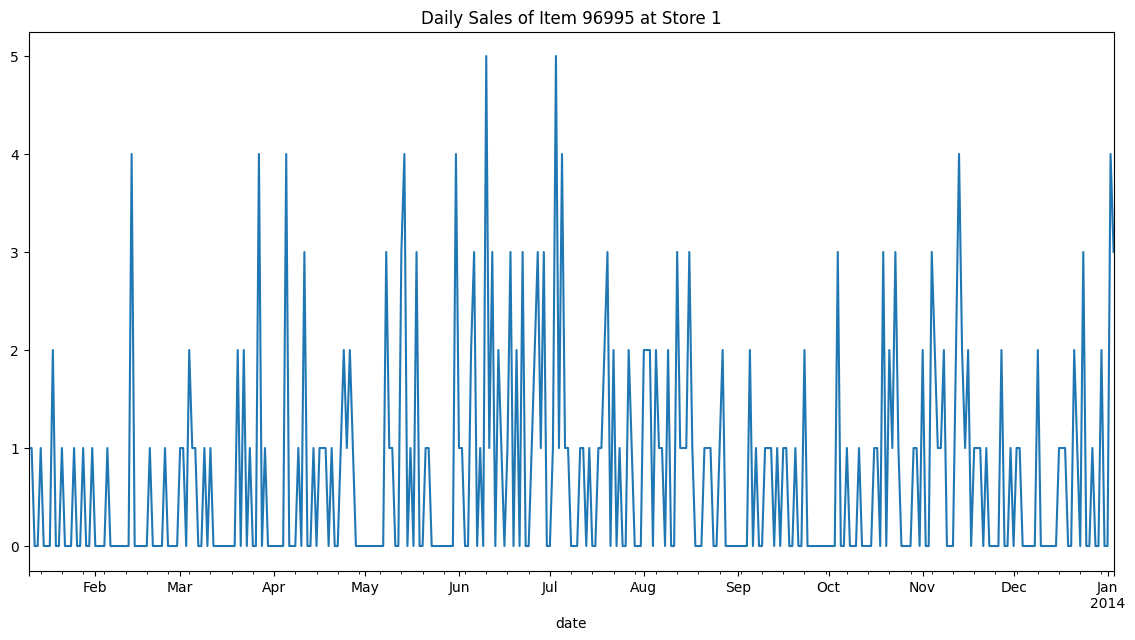

In [11]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Group by date and aggregate sales
df_filtered = df_filtered.groupby('date').sum()['unit_sales'].reset_index()

# Fill missing dates with zero sales
df_filtered.set_index('date', inplace=True)
df_filtered = df_filtered.asfreq('D').fillna(0)

# Visualize sales data
plt.figure(figsize=(14, 7))
df_filtered['unit_sales'].plot()
plt.title('Daily Sales of Item 96995 at Store 1')
plt.show()

# 3.5. Preprocessing the Data for LSTM

In [12]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_filtered['unit_sales'] = scaler.fit_transform(df_filtered[['unit_sales']])

# Create sequences of data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Set sequence length (e.g., past 30 days of sales)
seq_length = 30

# Create sequences
data = df_filtered['unit_sales'].values
X, y = create_sequences(data, seq_length)

# Split into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data to be [samples, time steps, features] for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# 3.6.LSTM model

In [13]:
pip install tensorflow

In [14]:
import tensorflow as tf
print("Eager execution:", tf.executing_eagerly())


Eager execution: True


In [15]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [17]:
# Assuming X_train has the shape (samples, time_steps, features)
seq_length = X_train.shape[1]  # The number of time steps


In [18]:
import tensorflow as tf

# Check if eager execution is enabled
print("Eager execution:", tf.executing_eagerly())

# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Convert training and validation data into TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

# Train the model using the dataset
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, verbose=1)


Eager execution: True


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - loss: 0.0665 - val_loss: 0.0590
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0549 - val_loss: 0.0480
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0476 - val_loss: 0.0439
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0465 - val_loss: 0.0441
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0478 - val_loss: 0.0439
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0471 - val_loss: 0.0446
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0472 - val_loss: 0.0447
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0461 - val_loss: 0.0443
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0477 - val_loss: 0.0439
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0467 - val_loss: 0.0437
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0477 - val_loss: 0.0438
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0480 - val_loss: 0.0439


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


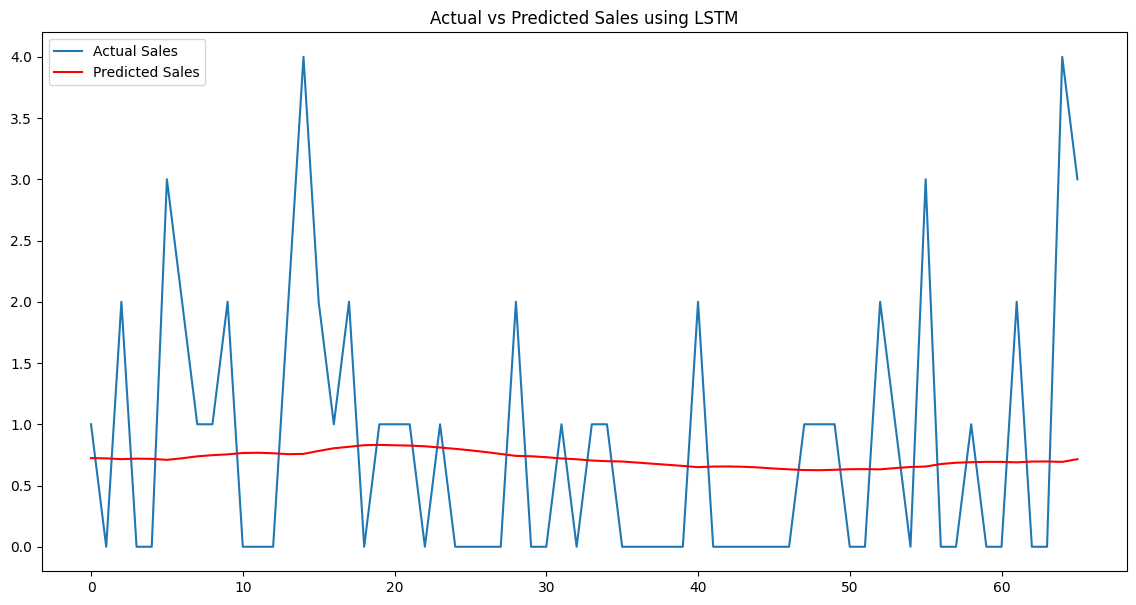

In [19]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using LSTM')
plt.legend()
plt.show()


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import numpy as np

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - loss: 0.0642 - val_loss: 0.0542
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 0.0514 - val_loss: 0.0445
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 0.0458 - val_loss: 0.0444
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 0.0462 - val_loss: 0.0437
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0424 - val_loss: 0.0443
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0450 - val_loss: 0.0443
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0450 - val_loss: 0.0443
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0511 - val_loss: 0.0441
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0463 - val_loss: 0.0445
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0435 - val_loss: 0.0448
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0489 - val_loss: 0.0443
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0423 - val_loss: 0.04

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step


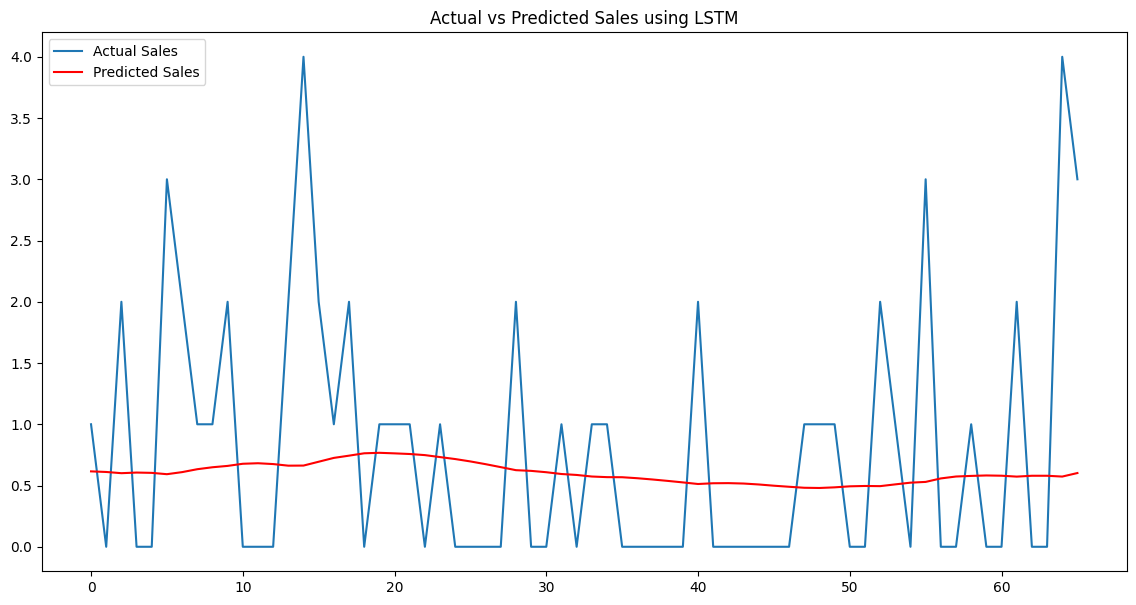

In [22]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using LSTM')
plt.legend()
plt.show()
